# DO NOT RUN THIS NOTEBOOK
# Create a copy of this notebook in your Google Drive / Google Colab to run

# Multi-Agent LangGraph Workshop (OpenAI GPT-4o Edition)

This notebook demonstrates a multi-step workflow using LangGraph, LangChain, and OpenAI's GPT-4o model. The workflow includes:

1. Search (expand + retrieve jobs)
2. Optional Enrich (add heuristic tags) - Not Included in workshop
3. Screen (Filter relevant jobs as per the Resume)
4. Human in the loop (User selects jobs for Resume tailoring)
5. Tailor (LLM powered Resume tailoring)

All LLM calls use OpenAI's GPT-4o via the latest LangChain API.

**Disclaimer:** All views expressed are our own and do not represent those of JPMorgan Chase & Co. References to any companies, brands, tools, or packages are for educational purposes only and do not imply endorsement or affiliation.

## 1. Environment Setup
Install required packages and set up your OpenAI API key. You need an OpenAI account and API key for GPT-4o access.

OpenAI API key is provided for this workshop.
After the workshop, you can create your OpenAI API key at https://platform.openai.com/account/api-keys

Tip: Avoid printing your key or storing it in notebooks. Prefer setting it via your terminal or a secrets manager.

## Dependencies

Install these packages (already provided in the install cell below):
- langgraph (workflow/interrupts)
- langchain (agents/tools)
- langchain-openai (OpenAI LLM wrapper)
- openai (client library)
- PyMuPDF (PDF parsing for resumes)
- requests (YC search HTTP calls)
- pydantic (used by LangChain)

Optional:
- tqdm (progress bars)

## How to Use This Notebook (Workshop)

- Goal: Search YC “Who’s hiring?” job board, screen jobs using your resume, and generate tailored resume bullets.
- What you’ll do:
  1. Install dependencies (one cell).
  2. Set OPENAI_API_KEY
  3. Run configuration and tool/agent setup cells in order.
  4. Run the graph execution cells to search → screen → human select → tailor.

Tip: If a cell errors, re-run from the top in order. If the API key isn’t set, the check cell will tell you.

## Quick Start

Follow these steps top-to-bottom. If something fails, restart the kernel and re-run in order.

1) Install dependencies
- Run the “Install packages” cell (uses %pip). A kernel restart may help.

2) Set your OpenAI API key
- Then run the “Check API key” cell. It should print that the key is set.

3) Configure the LLM
- Run the “OpenAI LLM Configuration” cell to create the GPT-4o client.

4) Load tools and agents
- Run the “ReAct Agent Tools” and “Agent Construction” cells.

5) Build the workflow graph
- Run the “LangGraph Configuration” cell (it compiles the graph).

6) Execute the graph (search → screen)
- Run the first “Graph Execution” cell. The graph will interrupt with a list of shortlisted jobs.

7) Human-in-the-loop selection
- Inspect the payload in the next cell and simulate choosing ~2 job IDs. Then resume the graph.

8) Tailored result
- The final cell prints keys of the tailored results and previews content written to `tailored_resume.txt`.

9) Use the Jane Doe resume PDF at the provided path before running the graph.

## Architecture at a Glance

- Agents
  - Search agent: Calls YCombinatorSearch to fetch jobs from HN “Who’s hiring?” and outputs a JSON array of jobs.
  - Screen agent: Uses ParseResumePDF to read your resume, then returns relevant jobs (JSON array) for the Resume provided.
  - Tailor agent: Uses ParseResumePDF, then writes tailored bullets via WriteTailoredResumeSection.

- Tools
  - YCombinatorSearch: Delegates to `yc_search.py` using HN forum to pull the latest month's thread and comments.
  - ParseResumePDF: Extracts text from the resume PDF using PyMuPDF.
  - WriteTailoredResumeSection: Appends generated content to `tailored_resume.txt`.

- Workflow (LangGraph)
  - search → (optional enrich) → screen → human_select (interrupt) → tailor → END
  - You choose which jobs to tailor during the interrupt. The graph then resumes and the tailor agent writes content.

- Output parsing policy
  - We parse only the agent’s final message content (not ToolMessages).
  - Agent prompts ask for JSON-only outputs; helper functions extract JSON from plain text or ```json code fences.

- Files to know
  - `yc_search.py`: Real YC search logic (HN Algolia, newest monthly thread → job comments).
  - `tailored_resume.txt`: Where tailored bullet points are appended.

Tip: Keep prompts minimal and structured to keep outputs strictly JSON for reliable parsing.

In [ ]:
# TODO: add 2 more keys and comment out all

In [ ]:
# # OPENAI API Key 3
# %env OPENAI_API_KEY=ADD_YOUR_KEY_HERE

In [ ]:
# Safety check (does not print the key)
import os
print("OPENAI_API_KEY is set" if os.getenv("OPENAI_API_KEY") else "OPENAI_API_KEY NOT set")

OPENAI_API_KEY is set


In [ ]:
%pip install --upgrade langgraph langchain langchain-openai openai pydantic pymupdf requests

In [ ]:
# Check package versions safely
import importlib.metadata as md

def v(pkg: str) -> str:
    try:
        return md.version(pkg)
    except Exception:
        return "not installed"

print("LangChain:", v("langchain"))
print("LangGraph:", v("langgraph"))
print("OpenAI:", v("openai"))
print("langchain-openai:", v("langchain-openai"))

LangChain: 1.0.3
LangGraph: 1.0.2
OpenAI: 2.7.1
langchain-openai: 1.0.2


## 2. OpenAI LLM Configuration
Set up OpenAI GPT-4o as the LLM provider using LangChain's OpenAI integration.

In [ ]:
import os
from langchain_openai import ChatOpenAI

# Set up the OpenAI GPT-4o LLM
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY is not set. In bash/zsh: export OPENAI_API_KEY=sk-...")

llm = ChatOpenAI(model="gpt-4o", api_key=openai_api_key, temperature=0.2)

## 3. ReAct Agent Tools
Define the tool set for job search, resume parsing, and resume tailoring. These tools are compatible with the latest LangChain and OpenAI GPT-4o.

In [ ]:
from typing import List, Dict, Optional
import json, os
from langchain_core.tools import tool

@tool("linkedInSearch") # Not used in this workshop
def linkedin_search(params, headers, terms: List[str], location: Optional[str] = None) -> List[Dict]:
    """
    Search LinkedIn jobs using BrightData API.

    Args:
        params: API query parameters.
        headers: API authorization headers.
        terms (List[str]): List of search keywords or job titles.
        location (Optional[str]): Job location; defaults to 'Remote'.

    Returns:
        List[Dict]: List of job postings as dictionaries.
    """
    location = location or "Remote"
    jobs = []

    try:
        for term in terms or []:
            data = [{
                "location": location,
                "keyword": term,
                "country": "US",
                "time_range": "Past month",
                "job_type": "Full-time",
                "experience_level": "Entry level",
                "remote": "On-site",
                "company": "",
                "location_radius": ""
            }]

            # Trigger dataset creation
            trigger_url = "https://api.brightdata.com/datasets/v3/trigger"
            trigger_response = requests.post(trigger_url, headers=headers, params=params, data=json.dumps(data))

            if trigger_response.status_code != 200:
                print(f"Failed to trigger dataset for '{term}'. Status: {trigger_response.status_code}")
                continue

            trigger_data = trigger_response.json()
            snapshot_id = trigger_data.get("snapshot_id")
            print(f"Triggered snapshot for '{term}' — ID: {snapshot_id}")

            # Poll for dataset readiness
            progress_url = f"https://api.brightdata.com/datasets/v3/progress/{snapshot_id}"
            while True:
                progress_response = requests.get(progress_url, headers=headers)
                if progress_response.status_code != 200:
                    print(f"Failed to check progress for '{term}'.")
                    break

                status = progress_response.json().get("status")
                print(f"Status for '{term}': {status}")

                if status == "ready":
                    break
                elif status == "running":
                    time.sleep(10)
                else:
                    print(f"Unexpected status '{status}' for '{term}'.")
                    break

            # Retrieve dataset when ready
            snapshot_url = f"https://api.brightdata.com/datasets/v3/snapshot/{snapshot_id}?format=json"
            snapshot_response = requests.get(snapshot_url, headers=headers)
            if snapshot_response.status_code != 200:
                print(f"Failed to fetch snapshot for '{term}'.")
                continue

            results = snapshot_response.json()
            for job in results:
                jobs.append({
                    "id": f"li_{job['job_posting_id']}",
                    "source": "linkedin",
                    "title": job.get("job_title", ""),
                    "company": job.get("company_name", ""),
                    "location": job.get("job_location", ""),
                    "summary": job.get("job_summary", ""),
                    "job_url": job.get("url", "")
                            })

    except Exception as e:
        print(f"Exception occurred: {e}")
        # Fallback example
        jobs.append({
            "id": "fallback_1",
            "source": "linkedin",
            "title": "Fallback Product Manager",
            "company": "Example Corp",
            "location": location,
            "summary": "Example summary for fallback case.",
            "job_url": "https://www.linkedin.com/jobs/"
        })

    return jobs

@tool("YCombinatorSearch")
def yc_search(terms: List[str], location: Optional[str] = None) -> List[Dict]:
    """Search Y Combinator (HN 'Who is hiring?') posts via helper script.

    Returns normalized job dicts: id, source, title, company, location, description, url
    """
    try:
        # Import the real implementation from the script we added to the workspace
        from yc_search import yc_search as yc_search_real
        results = yc_search_real(terms or [], location, limit=50)
        cleaned: List[Dict] = []
        for j in results or []:
            cleaned.append({
                "id": str(j.get("id") or ""),
                "source": "ycombinator",
                "title": j.get("title") or "",
                "company": j.get("company") or "",
                "location": j.get("location") or (location or ""),
                "description": j.get("description") or "",
                "url": j.get("url") or "",
            })
        return cleaned
    except Exception as e:
        # Fallback stub to avoid breaking the graph if import/network fails
        location = location or "Remote"
        jobs = []
        for i, t in enumerate(terms or []):
            jobs.append({
                "id": f"yc_{i}",
                "source": "ycombinator",
                "title": f"{t.title()} Engineer",
                "company": "StartupCo",
                "location": location,
                "description": f"Seeking {t} engineer to build MVP features across stack.",
            })
        return jobs

@tool("ParseResumePDF")
def parse_resume_pdf(path: str) -> str:
    """Parse resume PDF at path. Args: path (str). Returns extracted text or empty string."""
    try:
        import pymupdf
        if not os.path.exists(path):
            return ""
        doc = pymupdf.open(path)
        text = "\n".join(p.get_text() for p in doc)
        doc.close()
        return text
    except Exception:
        return ""

@tool("WriteTailoredResumeSection")
def write_tailored_resume_section(path: str, content: str) -> str:
    """Write tailored resume content to txt file. Args: path (str), content (str). Returns a status string."""
    try:
        path = path or "tailored_resume.txt"
        with open(path, "a", encoding="utf-8") as f:
            f.write(content + "\n\n")
        return f"Wrote content to {path}"
    except Exception as e:
        return f"Failed to write: {e}"


## 4. Agent Construction
Create ReAct agents using LangChain's OpenAI integration for search, screening, and tailoring operations.

In [ ]:
from langchain.agents import create_agent
import json
import re

# System prompts for each agent
SEARCH_SYSTEM = (
    """You are a job search agent. Given seed terms and optional location, call YCombinatorSearch to get job listings.
    After getting results, merge and return them as a single JSON array. You can expand on the seed terms and use multiple location information to find more relevant jobs.
    Make sure you output only the JSON array of jobs."""
)

SCREEN_SYSTEM = (
    """You are a screening agent. Use ParseResumePDF to load resume from path provided,
    then filter the relevant jobs based on the jobs and resume text. Return the relevant jobs as a single JSON array.
    Make sure you output only the JSON array of jobs"""
)

TAILOR_SYSTEM = (
    "You are a resume tailoring agent. Parse the resume (ParseResumePDF) then craft tailored content "
    "for each job, appending to a file via WriteTailoredResumeSection. Return a summary of actions taken."
)

# Build tool-calling agents using LangChain v1 create_agent API
search_tools = [yc_search] #[linkedin_search, yc_search]
screen_tools = [parse_resume_pdf]
tailor_tools = [parse_resume_pdf, write_tailored_resume_section]

search_agent_executor = create_agent(
    model="openai:gpt-4o",
    tools=search_tools,
    system_prompt=SEARCH_SYSTEM,
)

screen_agent_executor = create_agent(
    model="openai:gpt-4o",
    tools=screen_tools,
    system_prompt=SCREEN_SYSTEM,
)

tailor_agent_executor = create_agent(
    model="openai:gpt-4o",
    tools=tailor_tools,
    system_prompt=TAILOR_SYSTEM,
)

def extract_json_from_markdown(text: str) -> list:
    """
    Extract JSON array from a string that may contain markdown code blocks.

    Args:
        text: String that may contain JSON in markdown ```json blocks or plain text

    Returns:
        Parsed JSON array, or empty list if parsing fails
    """
    # Try to find JSON in markdown code block
    match = re.search(r'```(?:json)?\s*(\[.*?\])\s*```', text, re.DOTALL)
    if match:
        json_str = match.group(1)
    else:
        # Try to find JSON array directly in the text
        match = re.search(r'\[.*?\]', text, re.DOTALL)
        if match:
            json_str = match.group(0)
        else:
            return []

    try:
        return json.loads(json_str)
    except json.JSONDecodeError:
        return []


def extract_agent_results(result):
    # Take agent's final AI message content and extract JSON array from it
    try:
        msgs = result.get('messages', []) if isinstance(result, dict) else []
        if not msgs:
            return []
        answer = msgs[-1].content if hasattr(msgs[-1], 'content') else None
        print("Intermediate messages:")
        for m in msgs:
            # Check if it's a ToolMessage
            msg_type = type(m).__name__ if hasattr(m, '__class__') else None
            content = getattr(m, "content", None) if hasattr(m, "content") else m.get("content") if isinstance(m, dict) else None
            print(f"- Message type: {msg_type}, content: {str(content)}")

        print("Agent answer:", answer)
        if isinstance(answer, str):
            return extract_json_from_markdown(answer)
        return []
    except Exception:
        return []





def invoke_search(seed_terms: List[str], location: Optional[str] = None) -> List[Dict]:
    user_input = json.dumps({"terms": seed_terms, "location": location})
    result = search_agent_executor.invoke({
        "messages": [
            {"role": "user", "content": user_input}
        ]
    })
    jobs = extract_agent_results(result)
    return jobs if isinstance(jobs, list) else []


def invoke_screen(jobs: List[Dict], resume_path: str) -> List[Dict]:
    print(f"[invoke_screen] Called with {len(jobs)} jobs, resume_path='{resume_path}'")
    if not jobs:
        return []

    prompt = (
        # f"Use ScoreJobs to rank these {len(jobs)} jobs. "
        f"Given jobs={json.dumps(jobs)} and resume_path={resume_path}. "
        "Return the relevant jobs as a JSON array."
    )

    result = screen_agent_executor.invoke({
        "messages": [
            {"role": "user", "content": prompt}
        ]
    })

    filtered_jobs = extract_agent_results(result)
    return filtered_jobs


def invoke_tailor(selected_jobs: List[Dict], resume_path: str) -> Dict[str, str]:
    """
    Single-call tailoring: pass ALL selected_jobs in one prompt to the tailor_agent_executor.
    The agent should:
      1) Use ParseResumePDF to load the resume text.
      2) For EACH job, generate 4–6 bullets + a short summary.
      3) For EACH job, call WriteTailoredResumeSection(path='tailored_resume.txt', content=<tailored section>).
    Output requirement: Return ONLY a JSON array where each item has fields: id (job id) and preview (<=300 chars).

    Returns: Dict[job_id -> preview]
    """
    if not selected_jobs:
        return {}

    prompt = (
        "For the following jobs and the given resume path:\n"
        f"- Resume path: {resume_path or ''}\n"
        f"- Jobs: {json.dumps(selected_jobs)}\n\n"
        "Steps:\n"
        "1) Use ParseResumePDF to load the resume text.\n"
        "2) For each job, create 4-6 concise bullet points and a short summary aligning the resume to that job.\n"
        "3) For each job, call WriteTailoredResumeSection with path='tailored_resume.txt' and the tailored section.\n"
        "Output: Return ONLY a JSON array where each item is {{'id': <job id>, 'preview': <<=300 chars>}}. No prose."
    )

    try:
        result = tailor_agent_executor.invoke({
            "messages": [
                {"role": "user", "content": prompt}
            ]
        })
        msgs = result.get("messages", []) if isinstance(result, dict) else []
        final_text = ""
        if msgs:
            last = msgs[-1]
            final_text = getattr(last, "content", "") or ""
        arr = extract_json_from_markdown(final_text) if isinstance(final_text, str) else []
        if isinstance(arr, list):
            out: Dict[str, str] = {}
            for item in arr:
                jid = str((item or {}).get("id", "unknown"))
                prev = (item or {}).get("preview", "")
                out[jid] = prev
            return out
        return {}
    except Exception as e:
        return {"error": f"Tailor call failed: {e}"}

## 5. LangGraph Configuration
Set up the LangGraph workflow with nodes (and optional conditional branching) using the latest LangGraph syntax.

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict

# Proper StateGraph State with TypedDict
from typing import List, Dict, Any, Optional

class State(TypedDict, total=False):
    seed_terms: List[str]
    location: Optional[str]
    resume_pdf_path: str
    jobs: List[Dict]
    needs_enrichment: bool
    enriched_jobs: List[Dict]
    ranked_jobs: List[Dict]
    shortlisted_jobs: List[Dict]
    selected_jobs: List[Dict]
    tailored_resumes: Dict[str, str]

def build_graph():
    g = StateGraph(State)

    def n_search(s: State) -> State:
        terms = s.get("seed_terms", ["python","ml"])
        location = s.get("location")
        jobs = invoke_search(terms, location)
        # Fallback if agent returns nothing
        if not jobs:
            jobs = [
                {"id": "stub_li_0", "source": "linkedin", "title": "Python Engineer", "company": "EnterpriseCo", "location": location or "Remote", "description": "Looking for python engineers with cloud and data experience."},
                {"id": "stub_li_1", "source": "linkedin", "title": "Backend Engineer", "company": "ScaleUp", "location": location or "Remote", "description": "Looking for backend engineers with cloud and data experience."},
                {"id": "stub_yc_0", "source": "ycombinator", "title": "Python Engineer", "company": "StartupCo", "location": location or "Remote", "description": "Seeking python engineer to build MVP features across stack."},
            ]
        print(f"[n_search] jobs count: {len(jobs)}")
        return {
            **s,
            "jobs": jobs,
            "needs_enrichment": len(jobs) > 12
        }

    def n_enrich(s: State) -> State:
        enriched = []
        for j in s.get("jobs", []):
            j = dict(j)
            j["enriched_tag"] = "long-desc" if len(j.get("description","")) > 50 else "short-desc"
            enriched.append(j)
        print(f"[n_enrich] enriched_jobs count: {len(enriched)}")
        return {
            **s,
            "enriched_jobs": enriched
        }

    def n_screen(s: State) -> State:
        base_jobs = s.get("enriched_jobs") or s.get("jobs", [])
        print(f"[n_screen] base_jobs count: {len(base_jobs)}")
        resume_path = s.get("resume_pdf_path", "")
        ranked = invoke_screen(base_jobs, resume_path)
        print(f"[n_screen] ranked_jobs count: {len(ranked)}")
        return {
            **s,
            "ranked_jobs": ranked[:10],
            "shortlisted_jobs": ranked[:10]
        }

    def n_select(s: State) -> State:
        if "selected_jobs" not in s:
            payload = {
                "instruction": "Select top 2 job IDs or objects to tailor.",
                "ranked_jobs": s.get("ranked_jobs", []),
            }
            selection = interrupt(payload)
            chosen = []
            if isinstance(selection, list):
                if selection and isinstance(selection[0], str):
                    id_set = set(selection)
                    for j in s.get("ranked_jobs", []):
                        if j.get("id") in id_set and len(chosen) < 2:
                            chosen.append(j)
                elif selection and isinstance(selection[0], dict):
                    chosen = selection[:2]
            if not chosen:
                chosen = s.get("ranked_jobs", [])[:2]
            return {
                **s,
                "selected_jobs": chosen
            }
        return s

    def n_tailor(s: State) -> State:
        selected = s.get("selected_jobs", [])
        resume_path = s.get("resume_pdf_path", "")
        tailored = invoke_tailor(selected, resume_path)
        return {
            **s,
            "tailored_resumes": tailored
        }

    g.add_node("search_agent", n_search)
    g.add_node("enrich_node", n_enrich)
    g.add_node("screen_agent", n_screen)
    g.add_node("human_select_interrupt", n_select)
    g.add_node("tailor_agent", n_tailor)

    g.set_entry_point("search_agent")

    def route_from_search(s: State):
        return "enrich" if s.get("needs_enrichment") else "screen"

    g.add_conditional_edges("search_agent", route_from_search, {"enrich": "enrich_node", "screen": "screen_agent"})
    g.add_edge("enrich_node", "screen_agent")
    g.add_edge("screen_agent", "human_select_interrupt")
    g.add_edge("human_select_interrupt", "tailor_agent")
    g.add_edge("tailor_agent", END)

    return g.compile(checkpointer=MemorySaver())

graph_app = build_graph()

## 6. Graph Visualization
Generate a Mermaid diagram showing the workflow structure and branching logic.

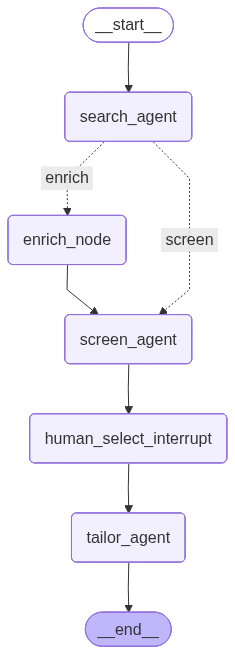

In [ ]:
# mermaid_str = graph_app.get_graph().draw_mermaid()
# print(mermaid_str)
from IPython.display import Image, display
graph_app.get_graph().draw_mermaid_png(output_file_path="workflow_graph.png")
image_path = '/content/workflow_graph.png'
display(Image(image_path))

## 7. Graph Execution
Run the graph with sample inputs and handle the conditional paths and interrupts.

In [ ]:
config = {"configurable": {"thread_id": "workshop-thread"}}
initial_state = {"seed_terms": ["python","full stack", "ml"], "location": "San Francisco", "resume_pdf_path": "Jane Doe Resume.pdf"}
first_result = graph_app.invoke(initial_state, config=config)
("__interrupt__" in first_result, list(first_result.keys()))

Intermediate messages:
- Message type: HumanMessage, content: {"terms": ["python", "full stack", "ml"], "location": "San Francisco"}
- Message type: AIMessage, content: 
- Message type: ToolMessage, content: [{"id": "hn_45802394", "source": "ycombinator", "title": "Time We're creating state of the art AI models, including the leading foundation model for Deepfake Detection", "company": "Resemble AI | San Francisco Bay Area (Mountain View, CA) | Full", "location": "San Francisco", "description": "Resemble AI | San Francisco Bay Area (Mountain View, CA) | Full-Time We're creating state of the art AI models, including the leading foundation model for Deepfake Detection. Looking for full stack, frontend and machine learning engineers that would love to create prototypes directly with the founders. Here's what we're looking for: Frontend Engineer - We're looking for a Frontend Engineer to build intuitive interfaces for our AI platform. You'll work with React/TypeScript to create exceptional

(True,
 ['seed_terms',
  'location',
  'resume_pdf_path',
  'jobs',
  'needs_enrichment',
  'ranked_jobs',
  'shortlisted_jobs',
  '__interrupt__'])

In [ ]:
first_result.get("__interrupt__", [])[0].value

{'instruction': 'Select top 2 job IDs or objects to tailor.',
 'ranked_jobs': [{'id': 'hn_45802394',
   'source': 'ycombinator',
   'title': "Time We're creating state of the art AI models, including the leading foundation model for Deepfake Detection",
   'company': 'Resemble AI | San Francisco Bay Area (Mountain View, CA) | Full',
   'location': 'San Francisco',
   'description': "Resemble AI | San Francisco Bay Area (Mountain View, CA) | Full-Time We're creating state of the art AI models, including the leading foundation model for Deepfake Detection. Looking for full stack, frontend and machine learning engineers that would love to create prototypes directly with the founders. Here's what we're looking for: Frontend Engineer - We're looking for a Frontend Engineer to build intuitive interfaces for our AI platform. You'll work with React/TypeScript to create exceptional user experiences that make complex AI technology accessible to both developers and enterprise users. Full Stack En

## 8. Human Interaction
Demonstrate how to handle human-in-the-loop interactions with the updated framework.

In [ ]:
# Inspect interrupt payload and resume execution
interrupts = first_result.get("__interrupt__", [])
if interrupts:
    payload = interrupts[0].value
    print("Instruction:", payload.get("instruction"))
    print("Payload keys:", list(payload.keys()))
    jobs = payload.get("shortlisted_jobs", []) or payload.get("ranked_jobs", [])
    print("Shortlisted count:", len(jobs))
    preview = [j.get("id") for j in jobs[:5]]
    print("Preview IDs:", preview)
    # Simulate human selection
    ids = [j.get("id") for j in jobs[:2]] # Selecting the first 2 jobs
    final_result = graph_app.invoke(Command(resume=ids), config=config)
else:
    final_result = first_result
final_result.get("tailored_resumes", {})

Instruction: Select top 2 job IDs or objects to tailor.
Payload keys: ['instruction', 'ranked_jobs']
Shortlisted count: 5
Preview IDs: ['hn_45802394', 'hn_45802400', 'hn_45803054', 'hn_45804691', 'hn_45813779']


{'hn_45802394': 'For the Frontend Engineer position at Resemble AI:\n\n- Over 5+ years of experience in developing scalable web applications using React and TypeScript, ...\nURL: https://news.ycombinator.com/item?id=45802394',
 'hn_45802400': 'For Full Stack Engineer at Chroma:\n\n- Comprehensive experience with both JavaScript and Python, essential for a Full Stack Engineer role...\nURL: https://news.ycombinator.com/item?id=45802400'}

In [ ]:
# Check final result
print("Final result keys:", list(final_result.keys()))
print("\nTailored resumes keys:", list(final_result.get("tailored_resumes", {}).keys()))
print("\nSample tailored content preview:")
for job_id, content in list(final_result.get("tailored_resumes", {}).items())[:2]:
    print(f"\n{job_id}:")
    print(content[:300] + "..." if len(content) > 300 else content)

Final result keys: ['seed_terms', 'location', 'resume_pdf_path', 'jobs', 'needs_enrichment', 'ranked_jobs', 'shortlisted_jobs', 'selected_jobs', 'tailored_resumes']

Tailored resumes keys: ['hn_45802394', 'hn_45802400']

Sample tailored content preview:

hn_45802394:
For the Frontend Engineer position at Resemble AI:

- Over 5+ years of experience in developing scalable web applications using React and TypeScript, ...
URL: https://news.ycombinator.com/item?id=45802394

hn_45802400:
For Full Stack Engineer at Chroma:

- Comprehensive experience with both JavaScript and Python, essential for a Full Stack Engineer role...
URL: https://news.ycombinator.com/item?id=45802400


## Troubleshooting

- OPENAI_API_KEY not set: Set it in your shell before starting Jupyter, then restart the kernel.
- Package import errors: Re-run the install cell (it uses %pip). If PyMuPDF fails, try restarting the kernel after install.
- Network hiccups (YC search): Re-run the search/screen cells. The script uses HN Algolia and may rate-limit briefly.
- Agent returned non-JSON: Re-run the cell; prompts request JSON-only output. If it persists, clear the kernel state and run from top.

Tip: Run cells in order from the top, and avoid skipping setup cells (install, API key check, LLM config).